In [489]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
import json

import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import pickle
from src.ode_helper_functions import *
from src.data_loading import preprocess_data, process_data, get_batch, get_batch_interpolation
from src.plots import plot_trajectories, plot_trajectories_new
# from src.evaluate import *

from src.evaluate_for_sankey import *

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP, GradModel, Graph_like_transformer
from torchcfm.utils import torch_wrapper

from sklearn.model_selection import train_test_split, KFold
import argparse

MODEL_REGISTRY = {
    "mlp": MLP,
    "graph_like_transformer": Graph_like_transformer,
    "gradmodel": GradModel,
    # Add more models here as needed
}

## cell-type static traj

In [490]:
# load scrna and multi_class_clf and label_encoder
# scRNA = sc.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE232025_stereoseq_g_10000_nzp_0.1.h5ad')
# multi_class_clf= pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE232025/multi_class_clf.pkl', 'rb'))
# label_encoder = pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE232025/label_encoder.pkl', 'rb'))

scRNA = sc.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE062025_MOSTA_g_10000_nzp_0.1.h5ad')
multi_class_clf= pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE062025/multi_class_clf.pkl', 'rb'))
label_encoder = pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE062025/label_encoder.pkl', 'rb'))


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.



In [491]:
## parameters

# # GSE232025
# params = {
#     "cfm_model": "mlp",
#     "dim": 50,
#     "out_dim": 50,
#     "time_varying": True,
#     "w": 10,
#     "use_celltype_conditional": False,
#     "trajectory_steps": 400,
# }

# GSE062025
params = {
    "cfm_model": "mlp",
    "dim": 50,
    "out_dim": 50,
    "time_varying": True,
    "w": 100,
    "use_celltype_conditional": False,
    "trajectory_steps": 400,
}

cell_type_key = 'celltype'
total_times = len(scRNA.obs['day'].unique())

# # # GSE232025
# train_idx = [0, 1, 2, 3]
# test_idx = [4]

# # GSE062025
train_idx = [0, 1, 2, 3, 4, 5, 6]
test_idx = [7]

cond_dim=0
device = 'cuda' if torch.cuda.is_available() else 'cpu'










In [492]:
import pickle


X_raw, data_df = preprocess_data(scRNA)
X_phate, X_phate_conditional, Spatial, Celltype_list, microenvironment_features, LR_features = process_data(scRNA, X_raw, cell_type_key, total_times, False, False, False, 'pca')
        

# load train/test data
train_idx, test_idx = sorted(train_idx), sorted(test_idx)


# always include the first timepoint in the training set
X_phate_train= [X_phate[i] for i in [0]+train_idx]
X_phate_conditional_train = [X_phate_conditional[i] for i in [0]+train_idx]

X_phate_test= [X_phate[i] for i in test_idx]
X_phate_conditional_test = [X_phate_conditional[i] for i in test_idx]



Spatial_train = [Spatial[i] for i in [0]+train_idx]
Spatial_test = [Spatial[i] for i in test_idx]

Celltype_list_train = [Celltype_list[i] for i in [0]+train_idx]
Celltype_list_test = [Celltype_list[i] for i in test_idx]

microenvironment_features_train = [microenvironment_features[i] for i in [0]+train_idx]
microenvironment_features_test = [microenvironment_features[i] for i in test_idx]

LR_features_train = [LR_features[i] for i in [0]+train_idx]
LR_features_test = [LR_features[i] for i in test_idx]


n_times = len(X_phate_train)


Day 0: 5913 cells, X_raw[0]: (5913, 2000)
Day 1: 18408 cells, X_raw[1]: (189017, 2000)
Day 2: 30124 cells, X_raw[2]: (220575, 2000)
Day 3: 51365 cells, X_raw[3]: (129088, 2000)
Day 4: 77369 cells, X_raw[4]: (88978, 2000)
Day 5: 102519 cells, X_raw[5]: (108735, 2000)
Day 6: 113350 cells, X_raw[6]: (116777, 2000)
Day 7: 121767 cells, X_raw[7]: (129038, 2000)


In [493]:
model_class = MODEL_REGISTRY.get(params['cfm_model'].lower())
ot_cfm_model = model_class(
    dim=(params['dim']+1 if params['use_celltype_conditional'] else params['dim']),
    out_dim=params['out_dim'],
    time_varying=params['time_varying'],
    w=params['w']
)

## in ivp and nextstep use 5000 points; reot_lr is the best model
# model_path='/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE232025/v_post_prior_correction_REOT_w_C_g_reg_lr/vi_pca_C_g_REOT1_lr'
# model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE232025/v_post_prior_correction_EOT_w_g/vi_pca_C_g_EOT_0_1_2'
# model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE232025/v_post_prior_correction_EOT_w_g+lr/vi_pca_C_g+lr_EOT1_0_1_2_3'



### in ivp and nextstep use 5000 points; eot3 is the best model
# model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/v_interp_post_prior_correction_EOT_w_g_ti5/vi_pca_C_g_EOT'
# model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/v_interp_post_prior_correction_REOT_w_C_g_reg_mc+lr_ti5/vi_pca_C_g_REOT3_mc+lr_0_1_2_3'
model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/v_interp_post_prior_correction_EOT_w_g+mc_ti5/vi_pca_C_g+mc_EOT3'
# model_path= '/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/v_interp_post_prior_correction_REOT_w_C_g_reg_mc+lr_ti5/vi_pca_C_g_REOT2_mc+lr'

ot_cfm_model.load_state_dict(torch.load(f'{model_path}/neural_ode_model.pth', map_location=torch.device('cpu')))

/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_31420/1636051560.py:22: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [494]:
node = NeuralODE(ConditionalODEVectorField(ot_cfm_model, cond_dim, params['dim']), solver="dopri5", sensitivity="adjoint")
init_size= 5000
with torch.no_grad():
    if params['use_celltype_conditional']:
        cfm_input = torch.cat([
            torch.from_numpy(X_phate_train[0][:init_size]).float().to(device),
            torch.from_numpy(X_phate_conditional_train[0][:init_size][:, None]).float().to(device)
        ], dim=-1)
    else:
        cfm_input = torch.from_numpy(X_phate_train[0][:init_size]).float().to(device)
        
    traj = node.trajectory(
        cfm_input,
        t_span=torch.linspace(0, len(X_phate_train)+len(X_phate_test) - 1, params['trajectory_steps']),
    ).cpu()

# because Celltype_list is empty when the use_celltype_conditional is false
ref_idx= [len(X_phate[i]) for i in range(len(X_phate))]
ref_idx= [sum(ref_idx[:i]) for i in range(len(ref_idx)+1)]
gt_labels = scRNA.obs['celltype'].values.tolist()
gt_labels = [gt_labels[ref_idx[i]:ref_idx[i+1]] for i in range(len(ref_idx)-1)]
weighted_wasserstein_data = {'clf_model': multi_class_clf, 'gt_labels': gt_labels, 'label_encoder': label_encoder}

mmd_list_next_step, wassersten_list_next_step, energy_list_next_step, r2_list_next_step, weighted_wasserstein_list_next_step, pred_celltype_names_next_step, gt_celltype_names_next_step = evaluate_next_step(node, X_phate, device, n_points= 5000, weighted_wasserstein_data=weighted_wasserstein_data)
metric_dict = {'mmd': mmd_list_next_step, 'wasserstein': wassersten_list_next_step, 'energy': energy_list_next_step, 'r2': r2_list_next_step, 'weighted_wasserstein': weighted_wasserstein_list_next_step}
    
mmd_list_IVP, wassersten_list_IVP, energy_list_IVP, r2_list_IVP, weighted_wasserstein_list_IVP, pred_celltype_names_IVP, gt_celltype_names_IVP = evaluate_IVP(traj, X_phate, device, weighted_wasserstein_data=weighted_wasserstein_data)
metric_dict_IVP = {'mmd': mmd_list_IVP, 'wasserstein': wassersten_list_IVP, 'energy': energy_list_IVP, 'r2': r2_list_IVP, 'weighted_wasserstein': weighted_wasserstein_list_IVP}


Evaluating: time 0 → 1
t=0 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 1 → 2
t=1 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 2 → 3
t=2 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 3 → 4
t=3 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 4 → 5
t=4 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 5 → 6
t=5 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
Evaluating: time 6 → 7
t=6 → t+1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, R2=0.0000, Weighted Wasserstein=0.0000
At t=0: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, Weighted Wasserstein=0.0000
At t=1: MMD=0.0000, Wasserstein=0.0000, Energy=0.0000, Weighted Wasserstein=0

In [495]:
# pred_celltype_names_next_step[0].shape
# pred_celltype_names_IVP[0].shape

In [496]:
# len(gt_celltype_names_next_step[0])
# len(gt_celltype_names_IVP[0])

In [497]:
# import plotly.graph_objects as go
# import pandas as pd
# import numpy as np

# def create_celltype_sankey(pred_celltype_names, gt_celltype_names, time_point=0):
#     """
#     Create a Sankey plot showing flow from ground truth to predicted cell types
    
#     Parameters:
#     -----------
#     pred_celltype_names : list
#         List of predicted cell type names for each time point
#     gt_celltype_names : list  
#         List of ground truth cell type names for each time point
#     time_point : int
#         Which time point to visualize (default: 0)
#     """

#     # Get data for specific time point
#     pred = pred_celltype_names[time_point]
#     gt = gt_celltype_names[time_point]
    
#     # Ensure same length - truncate gt to match pred length
#     min_len = min(len(pred), len(gt))
#     pred = pred[:min_len]
#     gt = gt[:min_len]
    
  
    
#     # Create DataFrame for easier manipulation
#     df = pd.DataFrame({
#         'ground_truth': gt,
#         'predicted': pred
#     })
    
#     # Get unique cell types
#     all_gt_types = sorted(df['ground_truth'].unique())
#     all_pred_types = sorted(df['predicted'].unique())
    
#     # Create node labels (GT on left, Pred on right)
#     node_labels = [f"GT: {ct}" for ct in all_gt_types] + [f"Pred: {ct}" for ct in all_pred_types]
    
#     # Create mapping dictionaries
#     gt_to_idx = {ct: i for i, ct in enumerate(all_gt_types)}
#     pred_to_idx = {ct: i + len(all_gt_types) for i, ct in enumerate(all_pred_types)}
    
#     # Count transitions
#     transition_counts = df.groupby(['ground_truth', 'predicted']).size().reset_index(name='count')
    
#     # Create source, target, and value lists for Sankey
#     source = [gt_to_idx[row['ground_truth']] for _, row in transition_counts.iterrows()]
#     target = [pred_to_idx[row['predicted']] for _, row in transition_counts.iterrows()]
#     values = transition_counts['count'].tolist()
    
#     # Create colors
#     n_gt = len(all_gt_types)
#     n_pred = len(all_pred_types)
    
#     # Colors for nodes (different colors for GT vs Pred)
#     node_colors = ['lightblue'] * n_gt + ['lightcoral'] * n_pred
    
#     # Colors for links (semi-transparent)
#     link_colors = ['rgba(100,149,237,0.4)'] * len(values)
    
#     # Create Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node = dict(
#             pad = 15,
#             thickness = 20,
#             line = dict(color = "black", width = 0.5),
#             label = node_labels,
#             color = node_colors
#         ),
#         link = dict(
#             source = source,
#             target = target,
#             value = values,
#             color = link_colors
#         )
#     )])
    
#     fig.update_layout(
#         title_text=f"Cell Type Predictions vs Ground Truth (Time Point {time_point})",
#         font_size=12,
#         width=1000,
#         height=600
#     )
    
#     return fig

# # Usage examples:

# # # For IVP evaluation results
# # fig_ivp = create_celltype_sankey(pred_celltype_names_IVP, gt_celltype_names_IVP, time_point=0)
# # fig_ivp.show()

# # For next step evaluation results  
# # fig_next = create_celltype_sankey(pred_celltype_names_next_step, gt_celltype_names_next_step, time_point=0)
# # fig_next.show()

# # Create plots for multiple time points
# for t in range(len(pred_celltype_names_IVP)):
#     fig = create_celltype_sankey(pred_celltype_names_IVP, gt_celltype_names_IVP, time_point=t)
#     fig.update_layout(title_text=f"Cell Type Predictions vs Ground Truth (Time Point {t})")
#     fig.show()

In [498]:
# import plotly.graph_objects as go
# import pandas as pd
# import numpy as np

# def create_temporal_sankey(celltype_names_list, title_prefix="Cell Type", time_labels=None):
#     """
#     Create a Sankey plot showing cell type transitions over time
    
#     Parameters:
#     -----------
#     celltype_names_list : list of arrays
#         List containing cell type names for each time point
#     title_prefix : str
#         Prefix for the plot title (e.g., "Predicted" or "Ground Truth")
#     time_labels : list
#         Custom labels for time points (default: Time 0, Time 1, etc.)
#     """
    
#     if time_labels is None:
#         time_labels = [f"Time {i}" for i in range(len(celltype_names_list))]
    
#     # Get all unique cell types across all time points
#     all_celltypes = set()
#     for celltype_names in celltype_names_list:
#         all_celltypes.update(celltype_names)
#     all_celltypes = sorted(list(all_celltypes))
    
#     # Create node labels: each cell type at each time point
#     node_labels = []
#     node_colors = []
    
#     # Color palette for different cell types
#     import matplotlib.cm as cm
#     colors = cm.Set3(np.linspace(0, 1, len(all_celltypes)))
#     celltype_color_map = {ct: f"rgba({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)},0.8)" 
#                          for ct, c in zip(all_celltypes, colors)}
    
#     # Create nodes for each time point
#     for t, time_label in enumerate(time_labels):
#         for celltype in all_celltypes:
#             node_labels.append(f"{celltype}\n({time_label})")
#             node_colors.append(celltype_color_map[celltype])
    
#     # Create mapping from (time, celltype) to node index
#     def get_node_idx(time_point, celltype):
#         return time_point * len(all_celltypes) + all_celltypes.index(celltype)
    
#     # Track transitions between consecutive time points
#     sources = []
#     targets = []
#     values = []
    
#     # For each consecutive pair of time points
#     for t in range(len(celltype_names_list) - 1):
#         current_celltypes = celltype_names_list[t]
#         next_celltypes = celltype_names_list[t + 1]
        
#         # Ensure same length by truncating to minimum
#         min_len = min(len(current_celltypes), len(next_celltypes))
#         current_celltypes = current_celltypes[:min_len]
#         next_celltypes = next_celltypes[:min_len]
        
#         # Count transitions
#         transition_df = pd.DataFrame({
#             'current': current_celltypes,
#             'next': next_celltypes
#         })
        
#         transition_counts = transition_df.groupby(['current', 'next']).size().reset_index(name='count')
        
#         # Add to sources, targets, values
#         for _, row in transition_counts.iterrows():
#             source_idx = get_node_idx(t, row['current'])
#             target_idx = get_node_idx(t + 1, row['next'])
            
#             sources.append(source_idx)
#             targets.append(target_idx)
#             values.append(row['count'])
    
#     # Create Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node = dict(
#             pad = 15,
#             thickness = 20,
#             line = dict(color = "black", width = 0.5),
#             label = node_labels,
#             color = node_colors,
#             x = [t / (len(time_labels) - 1) for t in range(len(time_labels)) for _ in all_celltypes],  # Position nodes by time
#             y = [i / len(all_celltypes) for _ in range(len(time_labels)) for i in range(len(all_celltypes))]  # Position nodes by cell type
#         ),
#         link = dict(
#             source = sources,
#             target = targets,
#             value = values,
#             color = ['rgba(100,149,237,0.3)'] * len(values)
#         )
#     )])
    
#     fig.update_layout(
#         title_text=f"{title_prefix} Cell Type Transitions Over Time",
#         font_size=10,
#         width=1200,
#         height=800
#     )
    
#     return fig

# # Create temporal Sankey for predicted cell types
# fig_pred_temporal = create_temporal_sankey(
#     pred_celltype_names_IVP, 
#     title_prefix="Predicted",
#     time_labels=[f"Day {i}" for i in range(len(pred_celltype_names_IVP))]
# )

# # Create temporal Sankey for ground truth cell types
# fig_gt_temporal = create_temporal_sankey(
#     gt_celltype_names_IVP, 
#     title_prefix="Ground Truth",
#     time_labels=[f"Day {i}" for i in range(len(gt_celltype_names_IVP))]
# )

# # Display the plots
# fig_pred_temporal.show()
# fig_gt_temporal.show()

# # Optional: Save the plots
# # fig_pred_temporal.write_html("predicted_temporal_sankey.html")
# # fig_gt_temporal.write_html("groundtruth_temporal_sankey.html")

In [499]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def create_clean_temporal_sankey(celltype_names_list, title_prefix="Cell Type", time_labels=None):
    """
    Create a clean temporal Sankey plot with clear x-axis time separation
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(celltype_names_list))]
    
    # Get all unique cell types across all time points
    all_celltypes = set()
    for celltype_names in celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Create color map for cell types
    import matplotlib.cm as cm
    colors = cm.tab20(np.linspace(0, 1, len(all_celltypes)))
    celltype_color_map = {ct: f"rgba({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)},0.8)" 
                         for ct, c in zip(all_celltypes, colors)}
    
    # Create nodes and their positions
    node_labels = []
    node_colors = []
    node_x = []
    node_y = []
    
    node_counter = 0
    time_to_celltype_to_node = {}  # {time: {celltype: node_index}}
    
    for t, time_label in enumerate(time_labels):
        time_to_celltype_to_node[t] = {}
        
        # Get cell types present at this time point
        present_celltypes = sorted(list(set(celltype_names_list[t])))
        
        for i, celltype in enumerate(present_celltypes):
            node_labels.append(f"{celltype}")
            node_colors.append(celltype_color_map[celltype])
            
            # Position nodes: x by time, y spread vertically
            node_x.append(t / (len(time_labels) - 1) if len(time_labels) > 1 else 0.5)
            node_y.append(i / max(1, len(present_celltypes) - 1) if len(present_celltypes) > 1 else 0.5)
            
            time_to_celltype_to_node[t][celltype] = node_counter
            node_counter += 1
    
    # Create transitions between consecutive time points
    sources = []
    targets = []
    values = []
    
    for t in range(len(celltype_names_list) - 1):
        current_celltypes = celltype_names_list[t]
        next_celltypes = celltype_names_list[t + 1]
        
        # Truncate to same length
        min_len = min(len(current_celltypes), len(next_celltypes))
        current_celltypes = current_celltypes[:min_len]
        next_celltypes = next_celltypes[:min_len]
        
        # Count transitions
        transition_df = pd.DataFrame({
            'current': current_celltypes,
            'next': next_celltypes
        })
        
        transition_counts = transition_df.groupby(['current', 'next']).size().reset_index(name='count')
        
        # Add transitions to sankey
        for _, row in transition_counts.iterrows():
            current_ct = row['current']
            next_ct = row['next']
            count = row['count']
            
            # Only add if both cell types have nodes at their respective time points
            if (current_ct in time_to_celltype_to_node[t] and 
                next_ct in time_to_celltype_to_node[t + 1]):
                
                source_idx = time_to_celltype_to_node[t][current_ct]
                target_idx = time_to_celltype_to_node[t + 1][next_ct]
                
                sources.append(source_idx)
                targets.append(target_idx)
                values.append(count)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 20,
            thickness = 25,
            line = dict(color = "black", width = 1),
            label = node_labels,
            color = node_colors,
            x = node_x,
            y = node_y
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            color = ['rgba(128,128,128,0.4)'] * len(values)
        )
    )])
    
    # Add time point annotations
    annotations = []
    for t, time_label in enumerate(time_labels):
        x_pos = t / (len(time_labels) - 1) if len(time_labels) > 1 else 0.5
        annotations.append(
            dict(
                x=x_pos,
                y=1.05,
                text=f"<b>{time_label}</b>",
                showarrow=False,
                xref="paper",
                yref="paper",
                font=dict(size=14)
            )
        )
    
    fig.update_layout(
        title_text=f"{title_prefix} Cell Type Transitions Over Time",
        font_size=12,
        width=1400,
        height=700,
        annotations=annotations
    )
    
    return fig

# # Create the clean temporal Sankey plots
fig_pred_clean_ivp = create_clean_temporal_sankey(
    pred_celltype_names_IVP, 
    title_prefix="Predicted IVP",
    time_labels=[f"Day {i}" for i in range(len(pred_celltype_names_IVP))]
)

# Create the clean temporal Sankey plots
fig_pred_clean_next_step = create_clean_temporal_sankey(
    pred_celltype_names_next_step, 
    title_prefix="Predicted next step",
    time_labels=[f"Day {i+1}" for i in range(len(pred_celltype_names_next_step))]
)

fig_gt_clean_ivp_gt = create_clean_temporal_sankey(
    gt_celltype_names_IVP, 
    title_prefix="Ground Truth",
    time_labels=[f"Day {i}" for i in range(len(gt_celltype_names_IVP))]
)

# Display the plots
fig_pred_clean_ivp.show()
fig_pred_clean_next_step.show()
fig_gt_clean_ivp_gt.show()

In [500]:
# len(pred_celltype_names_IVP)

In [501]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def create_temporal_celltype_histograms(pred_celltype_names_list, gt_celltype_names_list, time_labels=None):
    """
    Create time-varying histograms showing cell type distributions for GT and Predicted data
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(pred_celltype_names_list))]
    
    # Get all unique cell types across both datasets
    all_celltypes = set()
    for celltype_names in pred_celltype_names_list + gt_celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Create color map for cell types
    colors = px.colors.qualitative.Set3
    if len(all_celltypes) > len(colors):
        colors = colors * (len(all_celltypes) // len(colors) + 1)
    celltype_colors = {ct: colors[i] for i, ct in enumerate(all_celltypes)}
    
    # Prepare data for plotting
    plot_data = []
    
    for t, time_label in enumerate(time_labels):
        # Ground Truth data
        if t < len(gt_celltype_names_list):
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts()
            for celltype in all_celltypes:
                count = gt_counts.get(celltype, 0)
                plot_data.append({
                    'Time': time_label,
                    'Cell_Type': celltype,
                    'Count': count,
                    'Data_Type': 'Ground Truth',
                    'Time_Index': t
                })
        
        # Predicted data
        if t < len(pred_celltype_names_list):
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts()
            for celltype in all_celltypes:
                count = pred_counts.get(celltype, 0)
                plot_data.append({
                    'Time': time_label,
                    'Cell_Type': celltype,
                    'Count': count,
                    'Data_Type': 'Predicted',
                    'Time_Index': t
                })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots: one row for GT, one for Predicted
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Ground Truth Cell Type Distribution', 'Predicted Cell Type Distribution'),
        vertical_spacing=0.1
    )
    
    # Add GT histograms
    gt_data = df[df['Data_Type'] == 'Ground Truth']
    for celltype in all_celltypes:
        celltype_data = gt_data[gt_data['Cell_Type'] == celltype]
        if celltype_data['Count'].sum() > 0:  # Only plot if celltype exists
            fig.add_trace(
                go.Bar(
                    x=celltype_data['Time'],
                    y=celltype_data['Count'],
                    name=f'GT: {celltype}',
                    marker_color=celltype_colors[celltype],
                    legendgroup='gt',
                    legendgrouptitle_text="Ground Truth"
                ),
                row=1, col=1
            )
    
    # Add Predicted histograms
    pred_data = df[df['Data_Type'] == 'Predicted']
    for celltype in all_celltypes:
        celltype_data = pred_data[pred_data['Cell_Type'] == celltype]
        if celltype_data['Count'].sum() > 0:  # Only plot if celltype exists
            fig.add_trace(
                go.Bar(
                    x=celltype_data['Time'],
                    y=celltype_data['Count'],
                    name=f'Pred: {celltype}',
                    marker_color=celltype_colors[celltype],
                    marker_pattern_shape="/",  # Add pattern to distinguish from GT
                    legendgroup='pred',
                    legendgrouptitle_text="Predicted"
                ),
                row=2, col=1
            )
    
    fig.update_layout(
        title_text="Cell Type Distribution Over Time: Ground Truth vs Predicted",
        height=800,
        width=1200,
        barmode='stack',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        )
    )
    
    fig.update_xaxes(title_text="Time Point", row=2, col=1)
    fig.update_yaxes(title_text="Cell Count", row=1, col=1)
    fig.update_yaxes(title_text="Cell Count", row=2, col=1)
    
    return fig

def create_side_by_side_histograms(pred_celltype_names_list, gt_celltype_names_list, time_labels=None):
    """
    Create side-by-side histograms for easier comparison
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(pred_celltype_names_list))]
    
    # Get all unique cell types
    all_celltypes = set()
    for celltype_names in pred_celltype_names_list + gt_celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Create color map
    colors = px.colors.qualitative.Set3
    if len(all_celltypes) > len(colors):
        colors = colors * (len(all_celltypes) // len(colors) + 1)
    celltype_colors = {ct: colors[i] for i, ct in enumerate(all_celltypes)}
    
    # Create subplots for each time point
    n_times = len(time_labels)
    cols = min(4, n_times)  # Max 4 columns
    rows = (n_times + cols - 1) // cols
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"{label}" for label in time_labels],
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )
    
    for t, time_label in enumerate(time_labels):
        row = t // cols + 1
        col = t % cols + 1
        
        # Get GT and Pred counts for this time point
        if t < len(gt_celltype_names_list):
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts()
        else:
            gt_counts = pd.Series([], dtype=int)
            
        if t < len(pred_celltype_names_list):
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts()
        else:
            pred_counts = pd.Series([], dtype=int)
        
        # Add bars for each cell type
        celltypes_present = sorted(set(gt_counts.index.tolist() + pred_counts.index.tolist()))
        
        x_positions = np.arange(len(celltypes_present))
        width = 0.35
        
        # GT bars
        gt_values = [gt_counts.get(ct, 0) for ct in celltypes_present]
        pred_values = [pred_counts.get(ct, 0) for ct in celltypes_present]
        
        fig.add_trace(
            go.Bar(
                x=[f"{ct}" for ct in celltypes_present],
                y=gt_values,
                name='Ground Truth' if t == 0 else '',
                marker_color='lightblue',
                showlegend=(t == 0),
                offsetgroup=1
            ),
            row=row, col=col
        )
        
        fig.add_trace(
            go.Bar(
                x=[f"{ct}" for ct in celltypes_present],
                y=pred_values,
                name='Predicted' if t == 0 else '',
                marker_color='lightcoral',
                showlegend=(t == 0),
                offsetgroup=2
            ),
            row=row, col=col
        )
        
        # Update axes
        fig.update_xaxes(tickangle=45, row=row, col=col)
        fig.update_yaxes(title_text="Count" if col == 1 else "", row=row, col=col)
    
    fig.update_layout(
        title_text="Cell Type Distributions: Ground Truth vs Predicted (Side-by-Side)",
        height=300 * rows,
        width=1400,
        barmode='group'
    )
    
    return fig

# # Create both types of histograms
fig_stacked = create_temporal_celltype_histograms(pred_celltype_names_IVP, gt_celltype_names_IVP, 
                                                 time_labels=[f"Day {i}" for i in range(len(pred_celltype_names_IVP))])

fig_sidebyside = create_side_by_side_histograms(pred_celltype_names_IVP, gt_celltype_names_IVP,
                                               time_labels=[f"Day {i}" for i in range(len(pred_celltype_names_IVP))])

# # Display the plots
fig_stacked.show()
fig_sidebyside.show()

# Optional: Create a normalized version (percentages)
def create_normalized_histograms(pred_celltype_names_list, gt_celltype_names_list, time_labels=None):
    """
    Create normalized histograms showing percentages instead of raw counts
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(pred_celltype_names_list))]
    
    all_celltypes = set()
    for celltype_names in pred_celltype_names_list + gt_celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Create subplots for each time point
    n_times = len(time_labels)
    cols = min(4, n_times)
    rows = (n_times + cols - 1) // cols
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"{label}" for label in time_labels],
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )
    
    for t, time_label in enumerate(time_labels):
        row = t // cols + 1
        col = t % cols + 1
        
        # Get normalized counts
        if t < len(gt_celltype_names_list):
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts(normalize=True) * 100
        else:
            gt_counts = pd.Series([], dtype=float)
            
        if t < len(pred_celltype_names_list):
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts(normalize=True) * 100
        else:
            pred_counts = pd.Series([], dtype=float)
        
        celltypes_present = sorted(set(gt_counts.index.tolist() + pred_counts.index.tolist()))
        
        gt_values = [gt_counts.get(ct, 0) for ct in celltypes_present]
        pred_values = [pred_counts.get(ct, 0) for ct in celltypes_present]
        
        fig.add_trace(
            go.Bar(
                x=[f"{ct}" for ct in celltypes_present],
                y=gt_values,
                name='Ground Truth %' if t == 0 else '',
                marker_color='lightblue',
                showlegend=(t == 0),
                offsetgroup=1
            ),
            row=row, col=col
        )
        
        fig.add_trace(
            go.Bar(
                x=[f"{ct}" for ct in celltypes_present],
                y=pred_values,
                name='Predicted %' if t == 0 else '',
                marker_color='lightcoral',
                showlegend=(t == 0),
                offsetgroup=2
            ),
            row=row, col=col
        )
        
        fig.update_xaxes(tickangle=45, row=row, col=col)
        fig.update_yaxes(title_text="Percentage" if col == 1 else "", row=row, col=col, range=[0, 100])
    
    fig.update_layout(
        title_text="Cell Type Distributions: Ground Truth vs Predicted (Normalized %)",
        height=300 * rows,
        width=1400,
        barmode='group'
    )
    
    return fig

# # Create normalized version
fig_normalized = create_normalized_histograms(pred_celltype_names_IVP, gt_celltype_names_IVP,
                                            time_labels=[f"Day {i}" for i in range(len(pred_celltype_names_IVP))])
fig_normalized.show()

In [502]:
# Create normalized version
fig_normalized = create_normalized_histograms(pred_celltype_names_next_step, gt_celltype_names_next_step,
                                            time_labels=[f"Day {i+1}" for i in range(len(pred_celltype_names_next_step))])
fig_normalized.show()

In [503]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

def calculate_kl_divergence(p, q, epsilon=1e-10):
    """
    Calculate KL divergence between two probability distributions
    KL(P||Q) = sum(P * log(P/Q))
    
    Parameters:
    -----------
    p, q : array-like
        Probability distributions (will be normalized)
    epsilon : float
        Small value to avoid log(0)
    """
    # Normalize to probabilities
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL divergence
    return entropy(p, q)

def calculate_js_divergence(p, q):
    """
    Calculate Jensen-Shannon divergence (symmetric version of KL)
    """
    p = np.array(p)
    q = np.array(q)
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    
    return jensenshannon(p, q) ** 2

def create_histograms_with_divergence(pred_celltype_names_list, gt_celltype_names_list, time_labels=None):
    """
    Create histograms with KL divergence calculations displayed
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(pred_celltype_names_list))]
    
    # Get all unique cell types
    all_celltypes = set()
    for celltype_names in pred_celltype_names_list + gt_celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Calculate divergences for each time point
    kl_divergences = []
    js_divergences = []
    
    print("=== DIVERGENCE ANALYSIS ===")
    print(f"{'Time Point':<12} {'KL Div (GT||Pred)':<16} {'KL Div (Pred||GT)':<16} {'JS Divergence':<14}")
    print("-" * 70)
    
    for t, time_label in enumerate(time_labels):
        if t < len(gt_celltype_names_list) and t < len(pred_celltype_names_list):
            # Get counts for this time point
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts()
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts()
            
            # Align counts for all cell types
            gt_aligned = [gt_counts.get(ct, 0) for ct in all_celltypes]
            pred_aligned = [pred_counts.get(ct, 0) for ct in all_celltypes]
            
            # Calculate divergences
            kl_gt_pred = calculate_kl_divergence(gt_aligned, pred_aligned)
            kl_pred_gt = calculate_kl_divergence(pred_aligned, gt_aligned)
            js_div = calculate_js_divergence(gt_aligned, pred_aligned)
            
            kl_divergences.append((kl_gt_pred, kl_pred_gt))
            js_divergences.append(js_div)
            
            print(f"{time_label:<12} {kl_gt_pred:<16.4f} {kl_pred_gt:<16.4f} {js_div:<14.4f}")
    
    print("-" * 70)
    print(f"Mean KL (GT||Pred): {np.mean([kl[0] for kl in kl_divergences]):.4f}")
    print(f"Mean KL (Pred||GT): {np.mean([kl[1] for kl in kl_divergences]):.4f}")
    print(f"Mean JS Divergence: {np.mean(js_divergences):.4f}")
    print()
    
    # Create subplots for each time point with divergence info
    n_times = len(time_labels)
    cols = min(4, n_times)
    rows = (n_times + cols - 1) // cols
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"{label}<br>KL: {kl_divergences[t][0]:.3f}, JS: {js_divergences[t]:.3f}" 
                       if t < len(kl_divergences) else f"{label}" 
                       for t, label in enumerate(time_labels)],
        vertical_spacing=0.12,
        horizontal_spacing=0.08
    )
    
    for t, time_label in enumerate(time_labels):
        row = t // cols + 1
        col = t % cols + 1
        
        if t < len(gt_celltype_names_list) and t < len(pred_celltype_names_list):
            # Get counts
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts()
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts()
            
            celltypes_present = sorted(set(gt_counts.index.tolist() + pred_counts.index.tolist()))
            
            gt_values = [gt_counts.get(ct, 0) for ct in celltypes_present]
            pred_values = [pred_counts.get(ct, 0) for ct in celltypes_present]
            
            # Add bars
            fig.add_trace(
                go.Bar(
                    x=[f"{ct}" for ct in celltypes_present],
                    y=gt_values,
                    name='Ground Truth' if t == 0 else '',
                    marker_color='lightblue',
                    showlegend=(t == 0),
                    offsetgroup=1
                ),
                row=row, col=col
            )
            
            fig.add_trace(
                go.Bar(
                    x=[f"{ct}" for ct in celltypes_present],
                    y=pred_values,
                    name='Predicted' if t == 0 else '',
                    marker_color='lightcoral',
                    showlegend=(t == 0),
                    offsetgroup=2
                ),
                row=row, col=col
            )
        
        fig.update_xaxes(tickangle=45, row=row, col=col)
        fig.update_yaxes(title_text="Count" if col == 1 else "", row=row, col=col)
    
    fig.update_layout(
        title_text="Cell Type Distributions with KL & JS Divergence",
        height=350 * rows,
        width=1400,
        barmode='group'
    )
    
    return fig, kl_divergences, js_divergences

def create_divergence_timeline_plot(kl_divergences, js_divergences, time_labels):
    """
    Create a timeline plot showing how divergence changes over time
    """
    
    fig = go.Figure()
    
    # KL divergence GT||Pred
    fig.add_trace(go.Scatter(
        x=time_labels[:len(kl_divergences)],
        y=[kl[0] for kl in kl_divergences],
        mode='lines+markers',
        name='KL(GT||Pred)',
        line=dict(color='blue', width=2),
        marker=dict(size=8)
    ))
    
    # KL divergence Pred||GT
    fig.add_trace(go.Scatter(
        x=time_labels[:len(kl_divergences)],
        y=[kl[1] for kl in kl_divergences],
        mode='lines+markers',
        name='KL(Pred||GT)',
        line=dict(color='red', width=2),
        marker=dict(size=8)
    ))
    
    # JS divergence
    fig.add_trace(go.Scatter(
        x=time_labels[:len(js_divergences)],
        y=js_divergences,
        mode='lines+markers',
        name='JS Divergence',
        line=dict(color='green', width=2),
        marker=dict(size=8)
    ))
    
    fig.update_layout(
        title='Divergence Between GT and Predicted Cell Type Distributions Over Time',
        xaxis_title='Time Point',
        yaxis_title='Divergence',
        width=1000,
        height=500,
        legend=dict(x=0.02, y=0.98)
    )
    
    return fig

def create_normalized_histograms_with_divergence(pred_celltype_names_list, gt_celltype_names_list, time_labels=None):
    """
    Create normalized histograms (percentages) with divergence calculations
    """
    
    if time_labels is None:
        time_labels = [f"Time {i}" for i in range(len(pred_celltype_names_list))]
    
    all_celltypes = set()
    for celltype_names in pred_celltype_names_list + gt_celltype_names_list:
        all_celltypes.update(celltype_names)
    all_celltypes = sorted(list(all_celltypes))
    
    # Calculate divergences
    kl_divergences = []
    js_divergences = []

    print(f"{'Time Point':<12} {'KL Div (GT||Pred)':<16} {'KL Div (Pred||GT)':<16} {'JS Divergence':<14}")
    print("-" * 70)
    
    for t, time_label in enumerate(time_labels):
        if t < len(gt_celltype_names_list) and t < len(pred_celltype_names_list):
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts(normalize=True)
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts(normalize=True)
            
            gt_aligned = [gt_counts.get(ct, 0) for ct in all_celltypes]
            pred_aligned = [pred_counts.get(ct, 0) for ct in all_celltypes]
            
            kl_gt_pred = calculate_kl_divergence(gt_aligned, pred_aligned)
            kl_pred_gt = calculate_kl_divergence(pred_aligned, gt_aligned)
            js_div = calculate_js_divergence(gt_aligned, pred_aligned)
            
            kl_divergences.append((kl_gt_pred, kl_pred_gt))
            js_divergences.append(js_div)

            print(f"{time_label:<12} {kl_gt_pred:<16.4f} {kl_pred_gt:<16.4f} {js_div:<14.4f}")
    
    print("-" * 70)
    print(f"Mean KL (GT||Pred): {np.mean([kl[0] for kl in kl_divergences]):.4f}")
    print(f"Mean KL (Pred||GT): {np.mean([kl[1] for kl in kl_divergences]):.4f}")
    print(f"Mean JS Divergence: {np.mean(js_divergences):.4f}")
    print()
    
    # Create subplots
    n_times = len(time_labels)
    cols = min(4, n_times)
    rows = (n_times + cols - 1) // cols
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f"{label}<br>KL: {kl_divergences[t][0]:.3f}, JS: {js_divergences[t]:.3f}" 
                       if t < len(kl_divergences) else f"{label}" 
                       for t, label in enumerate(time_labels)],
        vertical_spacing=0.12,
        horizontal_spacing=0.08
    )
    
    for t, time_label in enumerate(time_labels):
        row = t // cols + 1
        col = t % cols + 1
        
        if t < len(gt_celltype_names_list) and t < len(pred_celltype_names_list):
            gt_counts = pd.Series(gt_celltype_names_list[t]).value_counts(normalize=True) * 100
            pred_counts = pd.Series(pred_celltype_names_list[t]).value_counts(normalize=True) * 100
            
            celltypes_present = sorted(set(gt_counts.index.tolist() + pred_counts.index.tolist()))
            
            gt_values = [gt_counts.get(ct, 0) for ct in celltypes_present]
            pred_values = [pred_counts.get(ct, 0) for ct in celltypes_present]
            
            fig.add_trace(
                go.Bar(
                    x=[f"{ct}" for ct in celltypes_present],
                    y=gt_values,
                    name='Ground Truth %' if t == 0 else '',
                    marker_color='lightblue',
                    showlegend=(t == 0),
                    offsetgroup=1
                ),
                row=row, col=col
            )
            
            fig.add_trace(
                go.Bar(
                    x=[f"{ct}" for ct in celltypes_present],
                    y=pred_values,
                    name='Predicted %' if t == 0 else '',
                    marker_color='lightcoral',
                    showlegend=(t == 0),
                    offsetgroup=2
                ),
                row=row, col=col
            )
        
        fig.update_xaxes(tickangle=45, row=row, col=col)
        fig.update_yaxes(title_text="Percentage" if col == 1 else "", row=row, col=col, range=[0, 100])
    
    fig.update_layout(
        title_text="Normalized Cell Type Distributions with KL & JS Divergence",
        height=350 * rows,
        width=1400,
        barmode='group'
    )
    
    return fig, kl_divergences, js_divergences

# Create histograms with divergence analysis
time_labels = [f"Day {i+1}" for i in range(len(pred_celltype_names_next_step))]

print("ANALYSIS FOR NEXT STEP PREDICTIONS:")
fig_with_div, kl_divs, js_divs = create_histograms_with_divergence(
    pred_celltype_names_next_step, 
    gt_celltype_names_next_step, 
    time_labels
)
print("ANALYSIS FOR NORMALIZED NEXT STEP PREDICTIONS:")
# Create normalized version
fig_norm_div, kl_divs_norm, js_divs_norm = create_normalized_histograms_with_divergence(
    pred_celltype_names_next_step, 
    gt_celltype_names_next_step, 
    time_labels
)

# Create divergence timeline
fig_timeline = create_divergence_timeline_plot(kl_divs, js_divs, time_labels)

# Display all plots
fig_with_div.show()
fig_norm_div.show()
fig_timeline.show()

# Optional: Analyze IVP predictions too
if 'pred_celltype_names_IVP' in locals():
    print("\nANALYSIS FOR IVP PREDICTIONS:")
    time_labels_ivp = [f"Day {i}" for i in range(len(pred_celltype_names_IVP))]
    print("ANALYSIS FOR IVP PREDICTIONS:")
    fig_ivp_div, kl_divs_ivp, js_divs_ivp = create_histograms_with_divergence(
        pred_celltype_names_IVP, 
        gt_celltype_names_IVP, 
        time_labels_ivp
    )
    print("ANALYSIS FOR NORMALIZED IVP PREDICTIONS:")
    fig_norm_ivp_div, kl_divs_ivp_norm, js_divs_ivp_norm = create_normalized_histograms_with_divergence(
        pred_celltype_names_IVP, 
        gt_celltype_names_IVP, 
        time_labels_ivp
    )
    
    fig_timeline_ivp = create_divergence_timeline_plot(kl_divs_ivp, js_divs_ivp, time_labels_ivp)
    
    fig_norm_ivp_div.show()
    fig_timeline_ivp.show()
    fig_ivp_div.show()
    

ANALYSIS FOR NEXT STEP PREDICTIONS:
=== DIVERGENCE ANALYSIS ===
Time Point   KL Div (GT||Pred) KL Div (Pred||GT) JS Divergence 
----------------------------------------------------------------------
Day 1        0.3530           2.0518           0.0871        
Day 2        0.6827           0.6523           0.1302        
Day 3        0.2165           0.4011           0.0521        
Day 4        0.1298           0.7930           0.0332        
Day 5        1.4564           1.2025           0.1479        
Day 6        0.9518           0.4052           0.0550        
Day 7        0.0845           0.2401           0.0214        
----------------------------------------------------------------------
Mean KL (GT||Pred): 0.5535
Mean KL (Pred||GT): 0.8209
Mean JS Divergence: 0.0753

ANALYSIS FOR NORMALIZED NEXT STEP PREDICTIONS:
Time Point   KL Div (GT||Pred) KL Div (Pred||GT) JS Divergence 
----------------------------------------------------------------------
Day 1        0.3530           1.


ANALYSIS FOR IVP PREDICTIONS:
ANALYSIS FOR IVP PREDICTIONS:
=== DIVERGENCE ANALYSIS ===
Time Point   KL Div (GT||Pred) KL Div (Pred||GT) JS Divergence 
----------------------------------------------------------------------
Day 0        0.0179           0.0174           0.0044        
Day 1        0.2249           0.3323           0.0394        
Day 2        0.1792           0.4177           0.0412        
Day 3        0.3713           0.7077           0.0468        
Day 4        0.3073           0.9018           0.0695        
Day 5        0.4907           0.8565           0.0939        
Day 6        0.5081           1.3098           0.1090        
Day 7        0.4691           0.6604           0.0849        
----------------------------------------------------------------------
Mean KL (GT||Pred): 0.3211
Mean KL (Pred||GT): 0.6505
Mean JS Divergence: 0.0611

ANALYSIS FOR NORMALIZED IVP PREDICTIONS:
Time Point   KL Div (GT||Pred) KL Div (Pred||GT) JS Divergence 
----------------------

In [504]:
# df_ivp_stereoseq= {'t0': pred_celltype_names_IVP[0], 't1': pred_celltype_names_IVP[1], 't2': pred_celltype_names_IVP[2], 't3': pred_celltype_names_IVP[3], 't4': pred_celltype_names_IVP[4]}
# df_next_step_stereoseq= {'t1': pred_celltype_names_next_step[0], 't2': pred_celltype_names_next_step[1], 't3': pred_celltype_names_next_step[2], 't4': pred_celltype_names_next_step[3]}

# df_ivp_stereoseq= pd.DataFrame.from_dict(df_ivp_stereoseq, orient='index')
# df_next_step_stereoseq= pd.DataFrame.from_dict(df_next_step_stereoseq, orient='index')

# df_ivp_stereoseq.to_csv('/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/df_ivp_stereoseq_SPOT.csv')
# df_next_step_stereoseq.to_csv('/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/df_next_step_stereoseq_SPOT.csv')


df_ivp_mosta= {'t0': pred_celltype_names_IVP[0], 't1': pred_celltype_names_IVP[1], 't2': pred_celltype_names_IVP[2], 't3': pred_celltype_names_IVP[3], 't4': pred_celltype_names_IVP[4], 't5': pred_celltype_names_IVP[5], 't6': pred_celltype_names_IVP[6], 't7': pred_celltype_names_IVP[7]}
df_next_step_mosta= {'t1': pred_celltype_names_next_step[0], 't2': pred_celltype_names_next_step[1], 't3': pred_celltype_names_next_step[2], 't4': pred_celltype_names_next_step[3], 't5': pred_celltype_names_next_step[4], 't6': pred_celltype_names_next_step[5], 't7': pred_celltype_names_next_step[6]}

df_ivp_mosta= pd.DataFrame.from_dict(df_ivp_mosta, orient='index')
df_next_step_mosta= pd.DataFrame.from_dict(df_next_step_mosta, orient='index')

df_ivp_mosta.to_csv('/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/df_ivp_mosta_SPOT.csv')
df_next_step_mosta.to_csv('/Users/rssantanu/Desktop/codebase/constrained_FM/experiment_figures/use_all_data_False_GSE062025/df_next_step_mosta_SPOT.csv')



## distilled results

In [507]:
ivp_kldiv_stereoseq_mot= [0.0014, 0.2994, 1.9586, 0.7965, 5.9394]
ivp_kldiv_stereoseq_mot_mean= np.mean(ivp_kldiv_stereoseq_mot)

ivp_kldiv_stereoseq_CTF= [0.0014, 0.2732, 1.7166, 0.885, 4.044]
ivp_kldiv_stereoseq_CTF_mean= np.mean(ivp_kldiv_stereoseq_CTF)


ivp_kldiv_mosta_mot= [0.0179, 0.1627, 0.1532, 0.2232, 0.2661, 0.6321, 0.682, 0.8346]
ivp_kldiv_mosta_mot_mean= np.mean(ivp_kldiv_mosta_mot)

ivp_kldiv_mosta_CTF= [0.0179, 0.2249, 0.1792, 0.3171, 0.3073, 0.4599, 0.5081, 0.4556]
ivp_kldiv_mosta_CTF_mean= np.mean(ivp_kldiv_mosta_CTF)

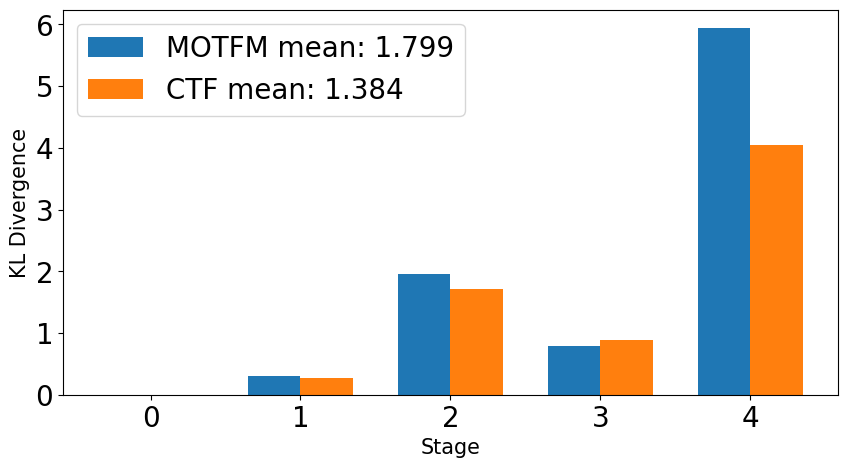

In [519]:
plt.figure(figsize=(10, 5))
x_pos = range(len(ivp_kldiv_stereoseq_mot))  # Create x positions
width = 0.35  # Width of bars

plt.bar([x - width/2 for x in x_pos], ivp_kldiv_stereoseq_mot, width, label=f'MOTFM mean: {ivp_kldiv_stereoseq_mot_mean:.3f}')
plt.bar([x + width/2 for x in x_pos], ivp_kldiv_stereoseq_CTF, width, label=f'CTF mean: {ivp_kldiv_stereoseq_CTF_mean:.3f}')

plt.xlabel('Stage', fontsize=15)
plt.ylabel('KL Divergence', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(x_pos, fontsize=20)  # Set x-tick positions
plt.yticks(fontsize=20)
plt.show()

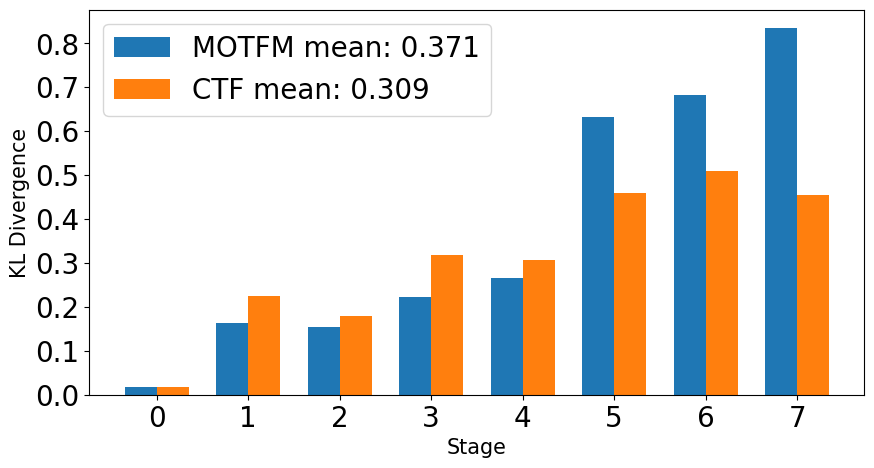

In [518]:
plt.figure(figsize=(10, 5))
x_pos = range(len(ivp_kldiv_mosta_mot))  # Create x positions
width = 0.35  # Width of bars

plt.bar([x - width/2 for x in x_pos], ivp_kldiv_mosta_mot, width, label=f'MOTFM mean: {ivp_kldiv_mosta_mot_mean:.3f}')
plt.bar([x + width/2 for x in x_pos], ivp_kldiv_mosta_CTF, width, label=f'CTF mean: {ivp_kldiv_mosta_CTF_mean:.3f}')

plt.xlabel('Stage', fontsize=15)
plt.ylabel('KL Divergence', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(x_pos, fontsize=20)  # Set x-tick positions
plt.yticks(fontsize=20)
plt.show()

## mosta extrapolation heatmap

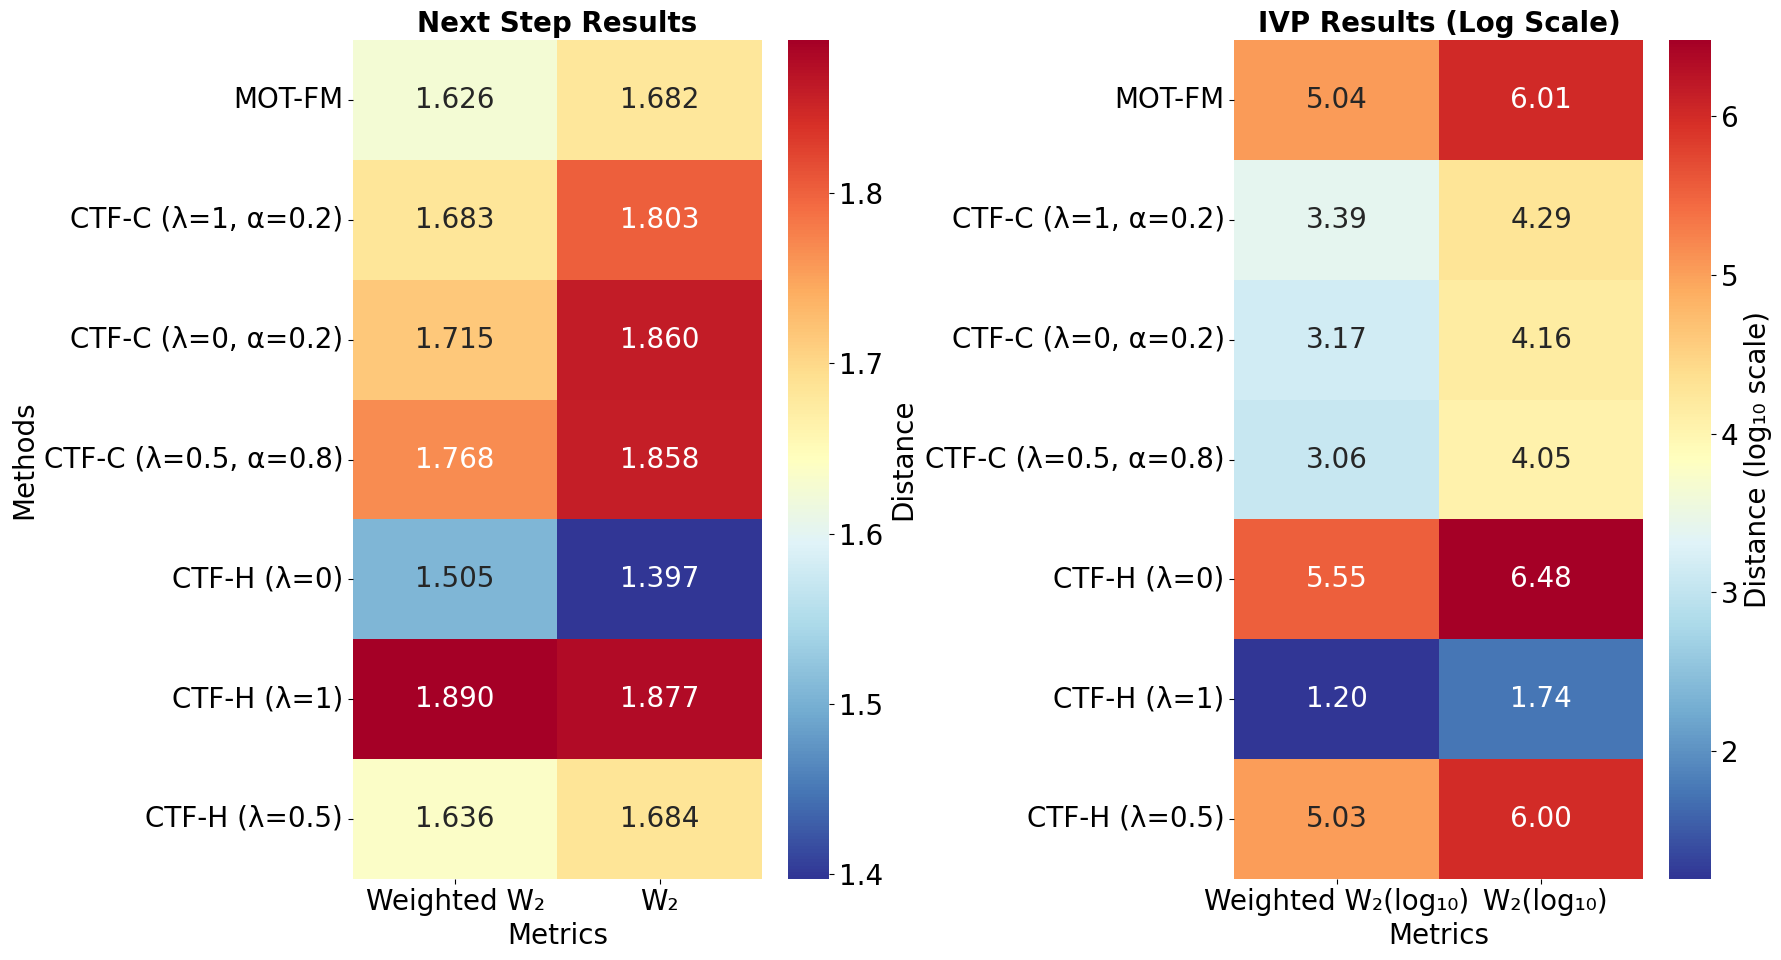

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set global font size
plt.rcParams.update({'font.size': 20})

# Data from your table
methods = ['MOT-FM', 'CTF-C (λ=1, α=0.2)', 'CTF-C (λ=0, α=0.2)', 'CTF-C (λ=0.5, α=0.8)', 
           'CTF-H (λ=0)', 'CTF-H (λ=1)', 'CTF-H (λ=0.5)']

# Next Step data (Weighted W2, W2)
next_step_data = np.array([
    [1.626, 1.682],
    [1.683, 1.803],
    [1.715, 1.860],
    [1.768, 1.858],
    [1.505, 1.397],  # Best values
    [1.890, 1.877],
    [1.636, 1.684]
])

# IVP data (Weighted W2, W2) - using log scale for better visualization
ivp_data = np.array([
    [110835, 1021005],
    [2473, 19537],
    [1493, 14563],
    [1158, 11138],
    [353428, 3011396],
    [14.729, 53.372],  # Best values
    [107889, 994606]
])

# Take log of IVP data for better visualization
ivp_data_log = np.log10(ivp_data + 1)  # +1 to handle any zeros

# Create DataFrames
next_step_df = pd.DataFrame(next_step_data, 
                           index=methods, 
                           columns=['Weighted W₂', 'W₂'])

ivp_df = pd.DataFrame(ivp_data_log, 
                     index=methods, 
                     columns=['Weighted W₂(log₁₀)', ' W₂(log₁₀)'])

# Create heatmaps with bigger fonts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Next Step heatmap
sns.heatmap(next_step_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            ax=ax1, cbar_kws={'label': 'Distance'}, annot_kws={'size': 20})
ax1.set_title('Next Step Results', fontsize=20, fontweight='bold')
ax1.set_ylabel('Methods', fontsize=20)
ax1.set_xlabel('Metrics', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

# IVP heatmap (log scale)
sns.heatmap(ivp_df, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            ax=ax2, cbar_kws={'label': 'Distance (log₁₀ scale)'}, annot_kws={'size': 20})
ax2.set_title('IVP Results (Log Scale)', fontsize=20, fontweight='bold')
ax2.set_ylabel('', fontsize=20)
ax2.set_xlabel('Metrics', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

## mosta interpolation heatmap

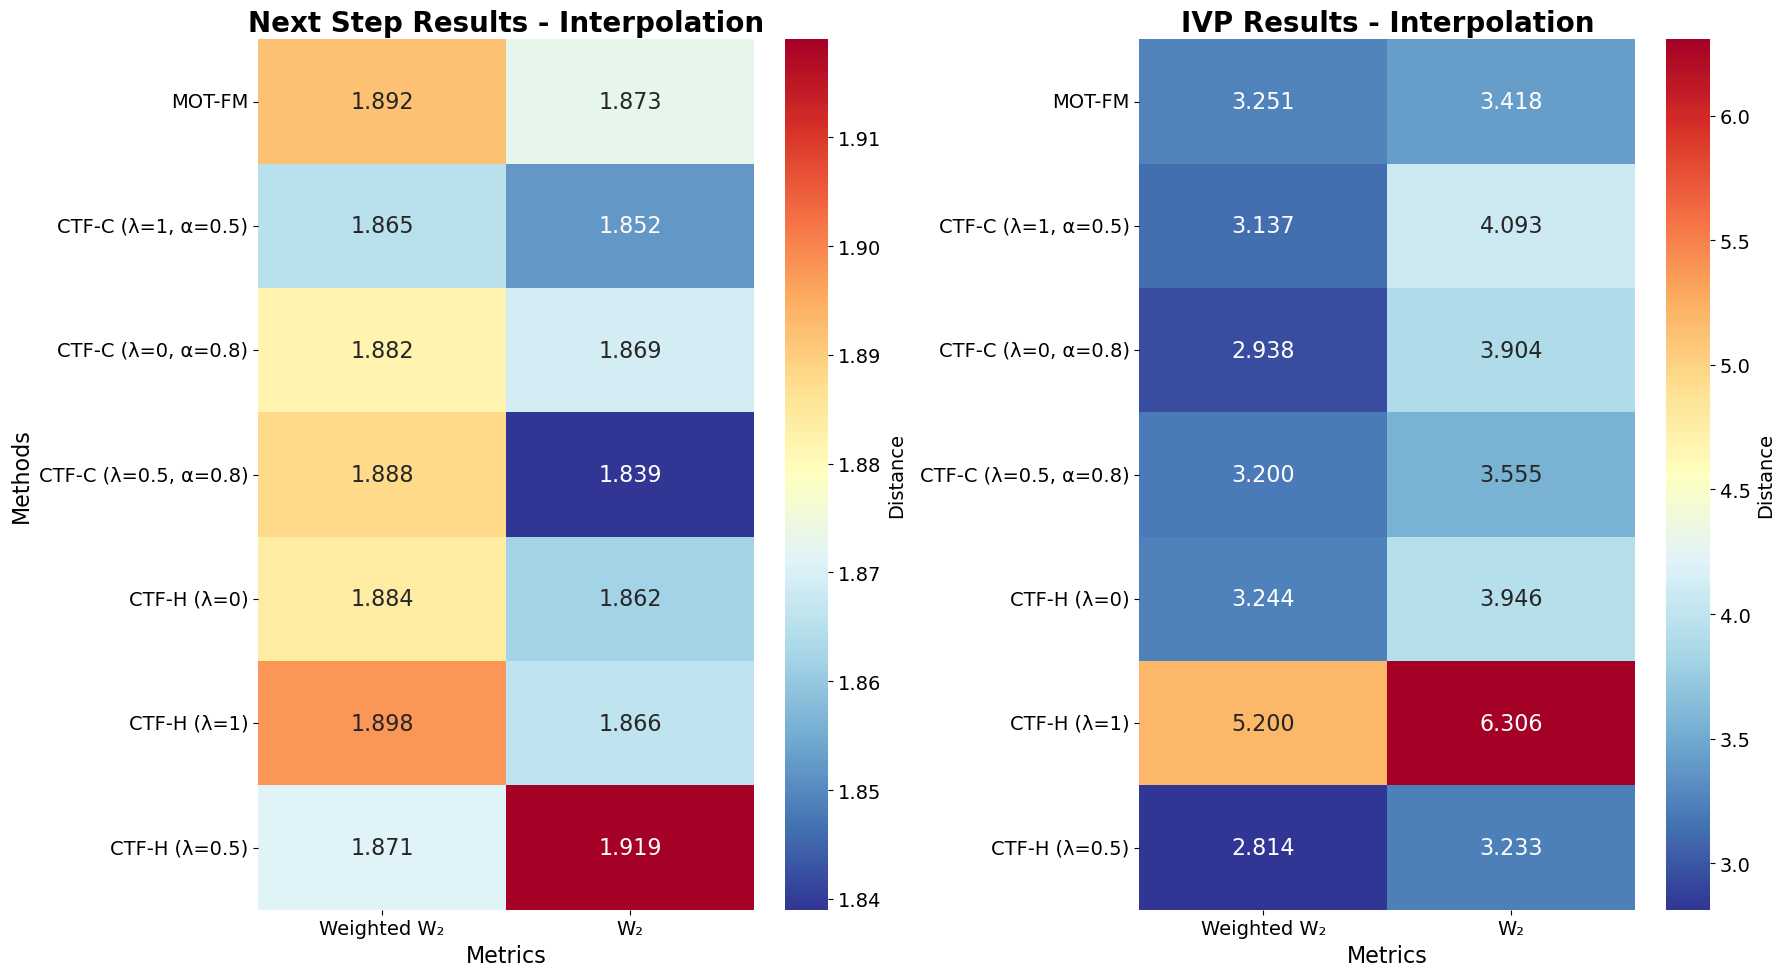

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set global font size
plt.rcParams.update({'font.size': 14})

# Data from your interpolation table
methods = ['MOT-FM', 'CTF-C (λ=1, α=0.5)', 'CTF-C (λ=0, α=0.8)', 'CTF-C (λ=0.5, α=0.8)', 
           'CTF-H (λ=0)', 'CTF-H (λ=1)', 'CTF-H (λ=0.5)']

# Next Step data (Weighted W2, W2)
next_step_data = np.array([
    [1.892, 1.873],
    [1.865, 1.852],  # Best weighted W2
    [1.882, 1.869],
    [1.888, 1.839],  # Best W2
    [1.884, 1.862],
    [1.898, 1.866],
    [1.871, 1.919]
])

# IVP data (Weighted W2, W2)
ivp_data = np.array([
    [3.251, 3.418],
    [3.137, 4.093],
    [2.938, 3.904],
    [3.200, 3.555],
    [3.244, 3.946],
    [5.200, 6.306],
    [2.814, 3.233]  # Best values
])

# Create DataFrames
next_step_df = pd.DataFrame(next_step_data, 
                           index=methods, 
                           columns=['Weighted W₂', 'W₂'])

ivp_df = pd.DataFrame(ivp_data, 
                     index=methods, 
                     columns=['Weighted W₂', 'W₂'])

# Create heatmaps with bigger fonts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Next Step heatmap
sns.heatmap(next_step_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            ax=ax1, cbar_kws={'label': 'Distance'}, annot_kws={'size': 16})
ax1.set_title('Next Step Results - Interpolation', fontsize=20, fontweight='bold')
ax1.set_ylabel('Methods', fontsize=16)
ax1.set_xlabel('Metrics', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# IVP heatmap
sns.heatmap(ivp_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            ax=ax2, cbar_kws={'label': 'Distance'}, annot_kws={'size': 16})
ax2.set_title('IVP Results - Interpolation', fontsize=20, fontweight='bold')
ax2.set_ylabel('', fontsize=16)
ax2.set_xlabel('Metrics', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

## liver dataset heatmap

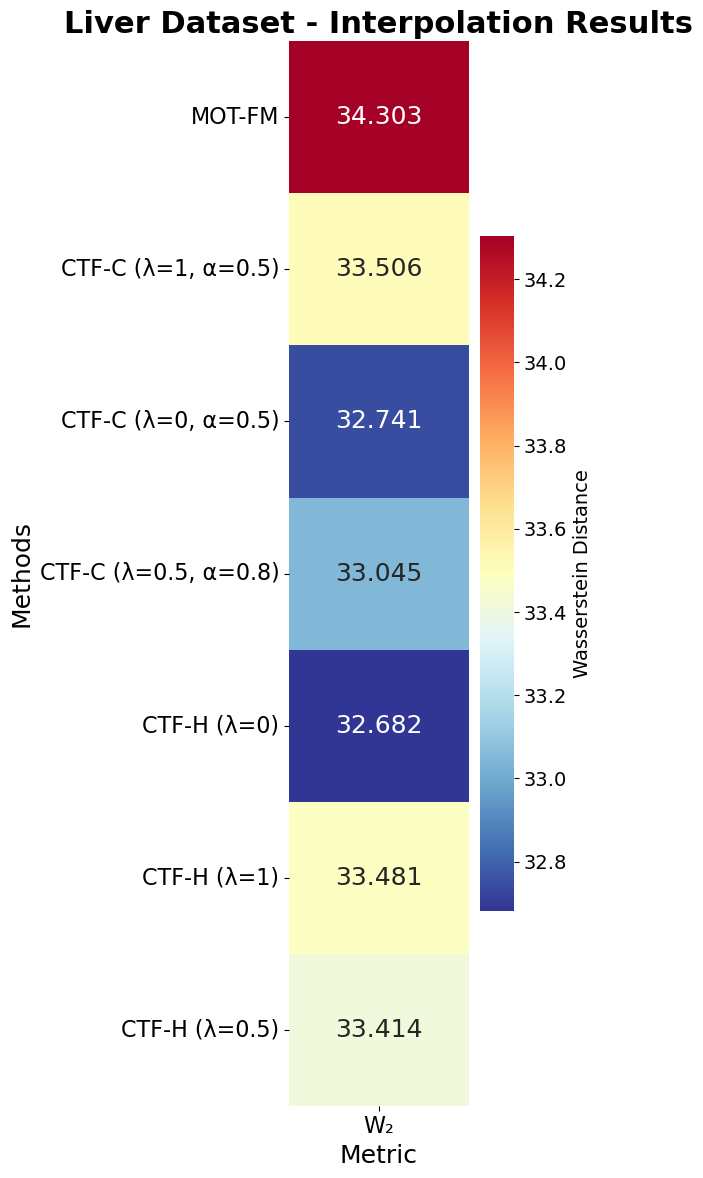

In [528]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set global font size
plt.rcParams.update({'font.size': 14})

# Data from your liver dataset table
methods = ['MOT-FM', 'CTF-C (λ=1, α=0.5)', 'CTF-C (λ=0, α=0.5)', 'CTF-C (λ=0.5, α=0.8)', 
           'CTF-H (λ=0)', 'CTF-H (λ=1)', 'CTF-H (λ=0.5)']

# W2 values (only one metric for this dataset)
w2_data = np.array([
    [34.303],
    [33.506],
    [32.741],
    [33.045],
    [32.682],  # Best value
    [33.481],
    [33.414]
])

# Create DataFrame
liver_df = pd.DataFrame(w2_data, 
                       index=methods, 
                       columns=['W₂'])

# Create heatmap
plt.figure(figsize=(6, 12))
sns.heatmap(liver_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            cbar_kws={'label': 'Wasserstein Distance'}, annot_kws={'size': 18})
plt.title('Liver Dataset - Interpolation Results', fontsize=22, fontweight='bold')
plt.ylabel('Methods', fontsize=18)
plt.xlabel('Metric', fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()
plt.show()